In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import transforms
import time
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# 绘图函数
import matplotlib.pyplot as plt
def draw_loss(train_loss, test_acc):
    x = range(len(train_loss))
    # 创建一个1行2列的图像布局
    plt.figure(figsize=(10, 5))
    # 在第一个子图中绘制训练损失
    plt.subplot(1, 2, 1)
    plt.plot(x, train_loss, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    # 在第二个子图中绘制测试精度
    plt.subplot(1, 2, 2)
    plt.plot(x, test_acc, color='r', label="Test Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [3]:
# minist数据集
mnist_train = torchvision.datasets.MNIST(root='~/Datasets/MNIST',train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='~/Datasets/MNIST',train=False, transform=transforms.ToTensor())
# 通过DataLoader 读取小批量数据样本
batch_size = 128
train_iter = DataLoader(mnist_train, batch_size=batch_size, shuffle=True,num_workers=0)
test_iter = DataLoader(mnist_test, batch_size=batch_size, shuffle=False,num_workers=0)

In [4]:
class Net(nn.Module):
    #网络定义
    def __init__(self,dropout=0.0):
        self.dropout = dropout
        num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
        W1 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1, num_inputs)), dtype=torch.float, requires_grad=True)
        b1 = torch.zeros(num_hiddens1, requires_grad=True)
        W2 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2, num_hiddens1)), dtype=torch.float, requires_grad=True)
        b2 = torch.zeros(num_hiddens2, requires_grad=True)
        W3 = torch.tensor(np.random.normal(0, 0.01, size=(num_outputs, num_hiddens2)), dtype=torch.float, requires_grad=True)
        b3 = torch.zeros(num_outputs, requires_grad=True)
        self.params = [W1, b1, W2, b2, W3, b3]
        # 定义模型结构
        self.input_layer = lambda x: x.view(x.shape[0], -1)
        self.hidden_layer1 = lambda x: torch.matmul(x, W1.t()) + b1
        self.hidden_layer2 = lambda x: torch.matmul(x, W2.t()) + b2
        self.output_layer = lambda x: torch.matmul(x, W3.t()) + b3
    
    # 训练状态
    def train(self):
        self.is_train = True
    def test(self):
        self.is_train = False
    
    def dropout_layer(self, x):
        dropout =self.dropout
        assert 0 <= dropout <= 1 
        #丢弃率在0-1之间
        if dropout == 1:
            return torch.zeros_like(x)
        if dropout == 0:
            return x
        #生成mask矩阵(向量)
        mask = (torch.rand(x.shape) < 1.0 - dropout).float()
        return mask * x / (1.0 - dropout)
    
    def forward(self, x):
        # 定义前向传播
        x = self.input_layer(x)
        if self.is_train:
            x = self.dropout_layer(x) 
        x = nn.ReLU()(self.hidden_layer1(x))
        if self.is_train:
            x = self.dropout_layer(x) 
        x = nn.ReLU()(self.hidden_layer2(x))
        if self.is_train:
            x = self.dropout_layer(x)
        x = self.output_layer(x)
        return x

In [5]:
# 测试准确率评价函数
def evaluate_accuracy(data_iter, model):
    acc_sum, n= 0.0, 0
    for X, y in data_iter:
        result = model.forward(X)
        acc_sum += (result.argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [6]:
# 训练函数
def train(net, train_iter, loss_func, epochs, optimizer):
    train_loss_list = []
    test_acc_list = []
    time_start = time.time()
    for epoch in range(epochs):
        train_l_sum, train_acc_sum, n, c = 0.0,0.0, 0,0
        # 训练状态
        net.train()
        for X,y in train_iter:
            y_hat = net.forward(X)
            l = loss_func(y_hat,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        # 测试状态
        net.test()
        test_acc = evaluate_accuracy(test_iter, net)
        train_loss_list.append(train_l_sum / c)
        test_acc_list.append(test_acc)
        print('epoch %d, train loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_l_sum / c, train_acc_sum / n, test_acc))
    print("time spend: %.6f second" % (time.time() - time_start))
    draw_loss(train_loss_list, test_acc_list)

In [7]:
epochs = 20
lr = 0.1
loss = nn.CrossEntropyLoss()

epoch 1, train loss 1.4783, train acc 0.489, test acc 0.863
epoch 2, train loss 0.3864, train acc 0.888, test acc 0.911
epoch 3, train loss 0.2751, train acc 0.921, test acc 0.937
epoch 4, train loss 0.2055, train acc 0.941, test acc 0.936
epoch 5, train loss 0.1620, train acc 0.953, test acc 0.959
epoch 6, train loss 0.1343, train acc 0.961, test acc 0.962
epoch 7, train loss 0.1139, train acc 0.967, test acc 0.967
epoch 8, train loss 0.0977, train acc 0.971, test acc 0.969
epoch 9, train loss 0.0850, train acc 0.975, test acc 0.970
epoch 10, train loss 0.0750, train acc 0.978, test acc 0.971
epoch 11, train loss 0.0664, train acc 0.981, test acc 0.972
epoch 12, train loss 0.0595, train acc 0.983, test acc 0.975
epoch 13, train loss 0.0527, train acc 0.984, test acc 0.976
epoch 14, train loss 0.0474, train acc 0.987, test acc 0.978
epoch 15, train loss 0.0422, train acc 0.988, test acc 0.977
epoch 16, train loss 0.0383, train acc 0.990, test acc 0.974
epoch 17, train loss 0.0343, trai

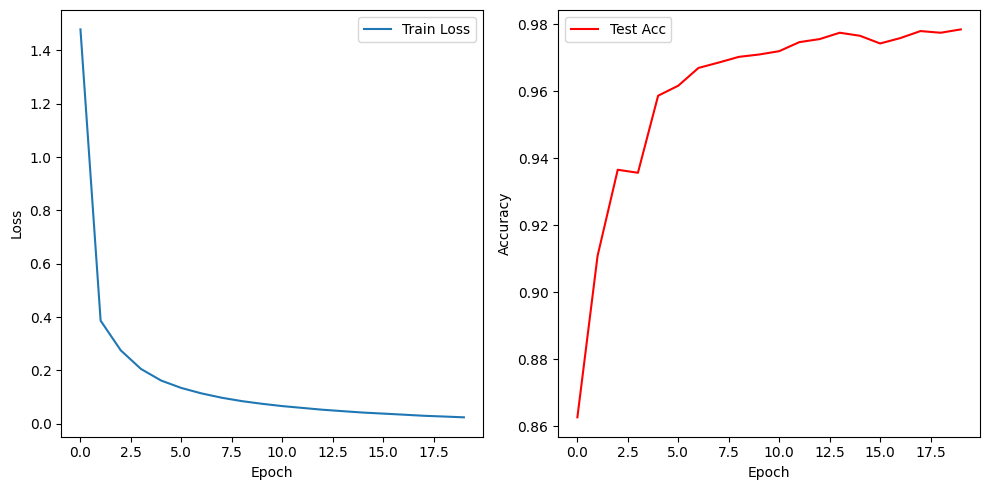

In [8]:
net = Net() # 先使dropout为0
optimizer = torch.optim.SGD(net.params, lr)
train(net, train_iter, loss, epochs, optimizer)

epoch 1, train loss 1.5587, train acc 0.459, test acc 0.834
epoch 2, train loss 0.4764, train acc 0.855, test acc 0.913
epoch 3, train loss 0.3283, train acc 0.902, test acc 0.939
epoch 4, train loss 0.2495, train acc 0.926, test acc 0.952
epoch 5, train loss 0.2025, train acc 0.940, test acc 0.961
epoch 6, train loss 0.1714, train acc 0.948, test acc 0.964
epoch 7, train loss 0.1525, train acc 0.955, test acc 0.971
epoch 8, train loss 0.1374, train acc 0.958, test acc 0.973
epoch 9, train loss 0.1247, train acc 0.962, test acc 0.975
epoch 10, train loss 0.1169, train acc 0.964, test acc 0.976
epoch 11, train loss 0.1078, train acc 0.967, test acc 0.977
epoch 12, train loss 0.1027, train acc 0.968, test acc 0.978
epoch 13, train loss 0.0969, train acc 0.970, test acc 0.979
epoch 14, train loss 0.0905, train acc 0.973, test acc 0.979
epoch 15, train loss 0.0859, train acc 0.974, test acc 0.979
epoch 16, train loss 0.0834, train acc 0.974, test acc 0.979
epoch 17, train loss 0.0787, trai

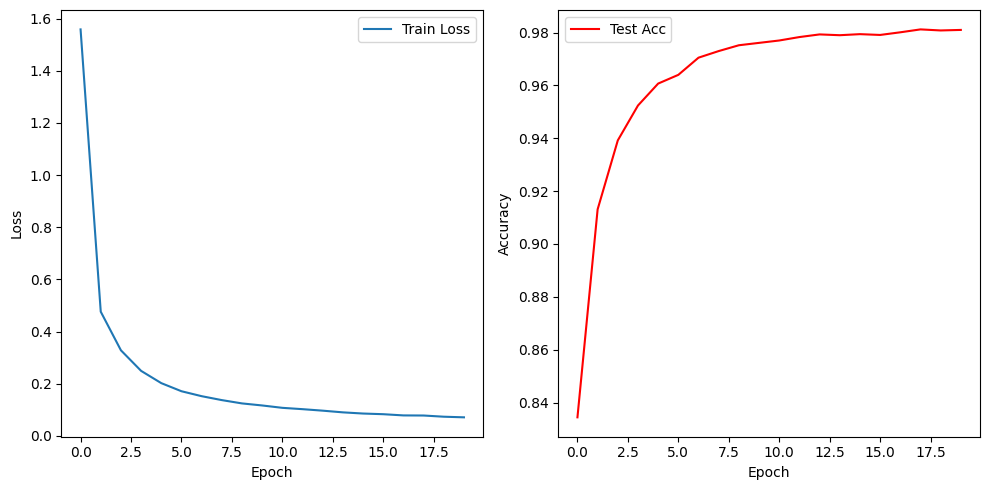

In [9]:
net = Net(0.2) # dropout为0.2
optimizer = torch.optim.SGD(net.params, lr)
train(net, train_iter, loss, epochs, optimizer)

epoch 1, train loss 1.7359, train acc 0.385, test acc 0.814
epoch 2, train loss 0.6562, train acc 0.791, test acc 0.915
epoch 3, train loss 0.4782, train acc 0.855, test acc 0.938
epoch 4, train loss 0.3937, train acc 0.879, test acc 0.944
epoch 5, train loss 0.3416, train acc 0.895, test acc 0.954
epoch 6, train loss 0.3142, train acc 0.903, test acc 0.955
epoch 7, train loss 0.2958, train acc 0.909, test acc 0.962
epoch 8, train loss 0.2799, train acc 0.915, test acc 0.964
epoch 9, train loss 0.2650, train acc 0.919, test acc 0.965
epoch 10, train loss 0.2568, train acc 0.922, test acc 0.966
epoch 11, train loss 0.2470, train acc 0.925, test acc 0.968
epoch 12, train loss 0.2370, train acc 0.927, test acc 0.969
epoch 13, train loss 0.2315, train acc 0.929, test acc 0.971
epoch 14, train loss 0.2303, train acc 0.929, test acc 0.970
epoch 15, train loss 0.2263, train acc 0.931, test acc 0.972
epoch 16, train loss 0.2203, train acc 0.933, test acc 0.972
epoch 17, train loss 0.2174, trai

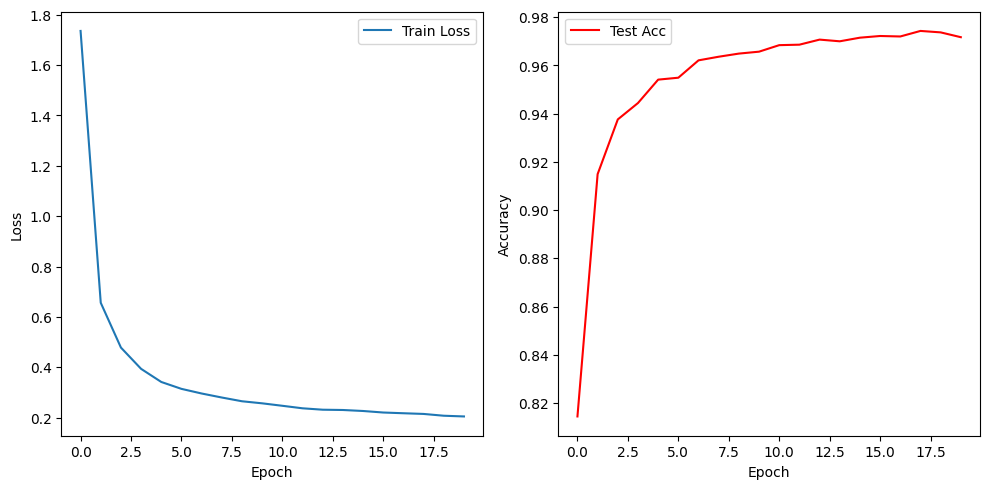

In [10]:
net = Net(0.5) # dropout为0.5
optimizer = torch.optim.SGD(net.params, lr)
train(net, train_iter, loss, epochs, optimizer)

epoch 1, train loss 2.0879, train acc 0.250, test acc 0.643
epoch 2, train loss 1.3148, train acc 0.547, test acc 0.801
epoch 3, train loss 1.1412, train acc 0.622, test acc 0.859
epoch 4, train loss 1.0684, train acc 0.647, test acc 0.878
epoch 5, train loss 1.0282, train acc 0.667, test acc 0.883
epoch 6, train loss 0.9966, train acc 0.678, test acc 0.903
epoch 7, train loss 0.9694, train acc 0.689, test acc 0.902
epoch 8, train loss 0.9543, train acc 0.699, test acc 0.909
epoch 9, train loss 0.9250, train acc 0.710, test acc 0.907
epoch 10, train loss 0.9215, train acc 0.713, test acc 0.908
epoch 11, train loss 0.9065, train acc 0.716, test acc 0.911
epoch 12, train loss 0.9006, train acc 0.718, test acc 0.913
epoch 13, train loss 0.8743, train acc 0.727, test acc 0.910
epoch 14, train loss 0.8881, train acc 0.726, test acc 0.914
epoch 15, train loss 0.8764, train acc 0.728, test acc 0.913
epoch 16, train loss 0.8703, train acc 0.732, test acc 0.916
epoch 17, train loss 0.8587, trai

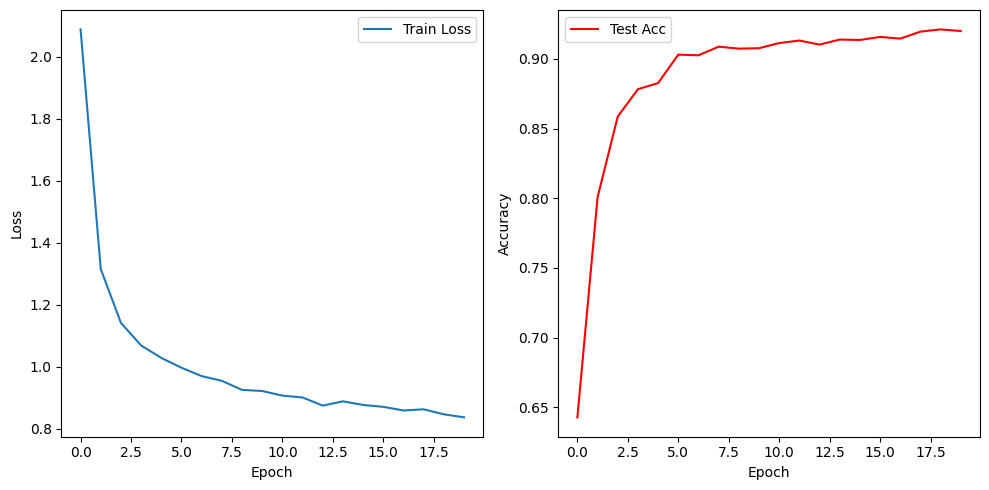

In [11]:
net = Net(0.8) # dropout为0.8
optimizer = torch.optim.SGD(net.params, lr)
train(net, train_iter, loss, epochs, optimizer)

In [12]:
# torch.nn.Dropout层实现dropout
class FlattenLayer(torch.nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [13]:
# 准确率计算函数
def evaluate_accuracy1(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        if isinstance(net,torch.nn.Module):
            net.eval() 
            #评估模式，不使用dropout
            acc_sum += (net (X).argmax (dim=1) == y).float ().sum().item()
            net.train()
            # 改回训练模式
        n += y.shape[0]
    return acc_sum / n

In [14]:
def train1(net, train_iter, loss_func, epochs, optimizer):
    train_loss_list = []
    test_acc_list = []
    time_start = time.time()
    for epoch in range(epochs):
        train_l_sum, train_acc_sum, n, c = 0.0,0.0, 0,0
        for X,y in train_iter:
            y_hat = net.forward(X)
            l = loss_func(y_hat,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        test_acc = evaluate_accuracy1(test_iter, net)
        train_loss_list.append(train_l_sum / c)
        test_acc_list.append(test_acc)
        print('epoch %d, train loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1,train_l_sum / c, train_acc_sum / n, test_acc))
    print("time spend: %.6f second" % (time.time() - time_start))
    draw_loss(train_loss_list, test_acc_list)

In [15]:
# 神经网络模型
def Net1(drop_prob): # 根据dropout的值来初始化
    drop_prob = 0.2
    net_pytorch = nn.Sequential(
        FlattenLayer(),
        nn.Linear(num_inputs, num_hiddens1),
        nn.ReLU(),
        nn.Dropout(drop_prob),
        nn.Linear(num_hiddens1, num_hiddens2),
        nn.ReLU(),
        nn.Dropout(drop_prob),
        nn.Linear(num_hiddens2, 10)
    )
    for param in net_pytorch.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net_pytorch

In [16]:
num_inputs = 784
num_hiddens1 = 256
num_hiddens2 = 256

epoch 1, train loss 1.5226, train acc 0.463, test acc 0.850
epoch 2, train loss 0.4189, train acc 0.877, test acc 0.918
epoch 3, train loss 0.2870, train acc 0.916, test acc 0.938
epoch 4, train loss 0.2169, train acc 0.937, test acc 0.949
epoch 5, train loss 0.1750, train acc 0.949, test acc 0.959
epoch 6, train loss 0.1471, train acc 0.957, test acc 0.964
epoch 7, train loss 0.1279, train acc 0.962, test acc 0.967
epoch 8, train loss 0.1143, train acc 0.967, test acc 0.969
epoch 9, train loss 0.1029, train acc 0.970, test acc 0.972
epoch 10, train loss 0.0939, train acc 0.972, test acc 0.975
epoch 11, train loss 0.0851, train acc 0.974, test acc 0.976
epoch 12, train loss 0.0781, train acc 0.977, test acc 0.976
epoch 13, train loss 0.0733, train acc 0.978, test acc 0.977
epoch 14, train loss 0.0678, train acc 0.979, test acc 0.977
epoch 15, train loss 0.0618, train acc 0.982, test acc 0.980
epoch 16, train loss 0.0611, train acc 0.981, test acc 0.978
epoch 17, train loss 0.0556, trai

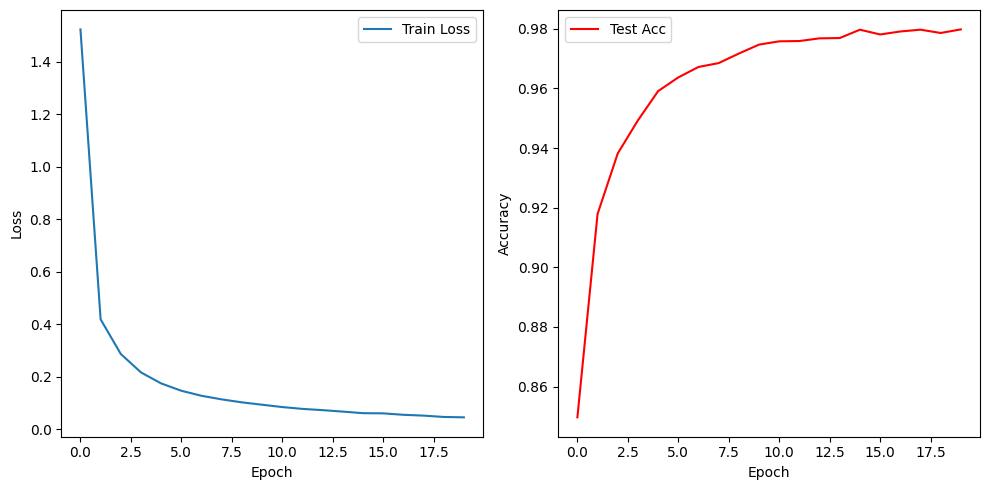

In [17]:
net = Net1(0.2) # dropout为0.2
optimizer = torch.optim.SGD(net.parameters(), lr)
train1(net, train_iter, loss, epochs, optimizer)

epoch 1, train loss 1.4722, train acc 0.491, test acc 0.858
epoch 2, train loss 0.4196, train acc 0.877, test acc 0.910
epoch 3, train loss 0.2867, train acc 0.917, test acc 0.937
epoch 4, train loss 0.2142, train acc 0.938, test acc 0.951
epoch 5, train loss 0.1742, train acc 0.949, test acc 0.957
epoch 6, train loss 0.1475, train acc 0.957, test acc 0.963
epoch 7, train loss 0.1287, train acc 0.962, test acc 0.967
epoch 8, train loss 0.1134, train acc 0.967, test acc 0.968
epoch 9, train loss 0.1022, train acc 0.969, test acc 0.972
epoch 10, train loss 0.0921, train acc 0.973, test acc 0.972
epoch 11, train loss 0.0843, train acc 0.975, test acc 0.974
epoch 12, train loss 0.0772, train acc 0.977, test acc 0.977
epoch 13, train loss 0.0721, train acc 0.979, test acc 0.978
epoch 14, train loss 0.0666, train acc 0.980, test acc 0.978
epoch 15, train loss 0.0622, train acc 0.981, test acc 0.980
epoch 16, train loss 0.0572, train acc 0.982, test acc 0.979
epoch 17, train loss 0.0542, trai

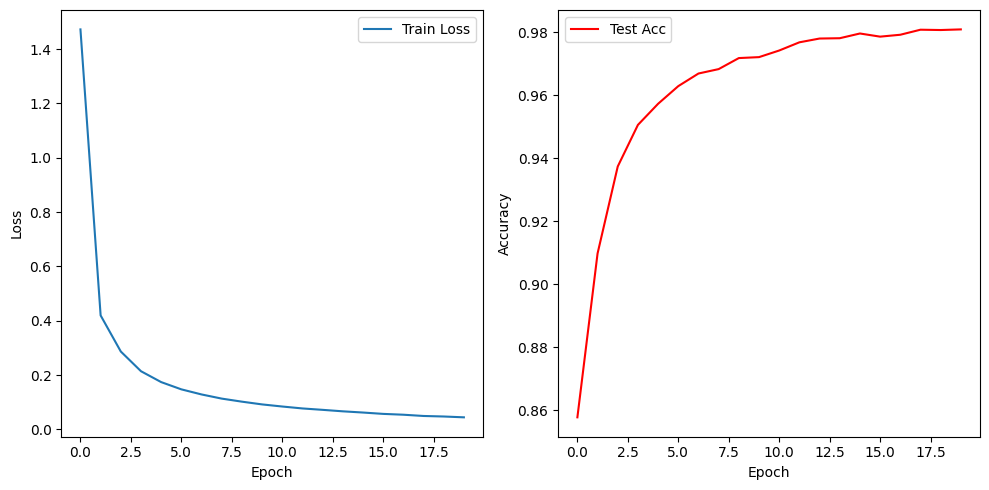

In [18]:
net = Net1(0.5) # dropout为0.5
optimizer = torch.optim.SGD(net.parameters(), lr)
train1(net, train_iter, loss, epochs, optimizer)

epoch 1, train loss 1.4916, train acc 0.477, test acc 0.862
epoch 2, train loss 0.4150, train acc 0.879, test acc 0.911
epoch 3, train loss 0.2847, train acc 0.917, test acc 0.938
epoch 4, train loss 0.2165, train acc 0.937, test acc 0.953
epoch 5, train loss 0.1729, train acc 0.949, test acc 0.960
epoch 6, train loss 0.1472, train acc 0.957, test acc 0.966
epoch 7, train loss 0.1293, train acc 0.962, test acc 0.970
epoch 8, train loss 0.1142, train acc 0.967, test acc 0.973
epoch 9, train loss 0.1036, train acc 0.969, test acc 0.973
epoch 10, train loss 0.0927, train acc 0.973, test acc 0.975
epoch 11, train loss 0.0854, train acc 0.975, test acc 0.976
epoch 12, train loss 0.0796, train acc 0.976, test acc 0.978
epoch 13, train loss 0.0732, train acc 0.978, test acc 0.978
epoch 14, train loss 0.0669, train acc 0.980, test acc 0.977
epoch 15, train loss 0.0613, train acc 0.981, test acc 0.980
epoch 16, train loss 0.0602, train acc 0.982, test acc 0.981
epoch 17, train loss 0.0561, trai

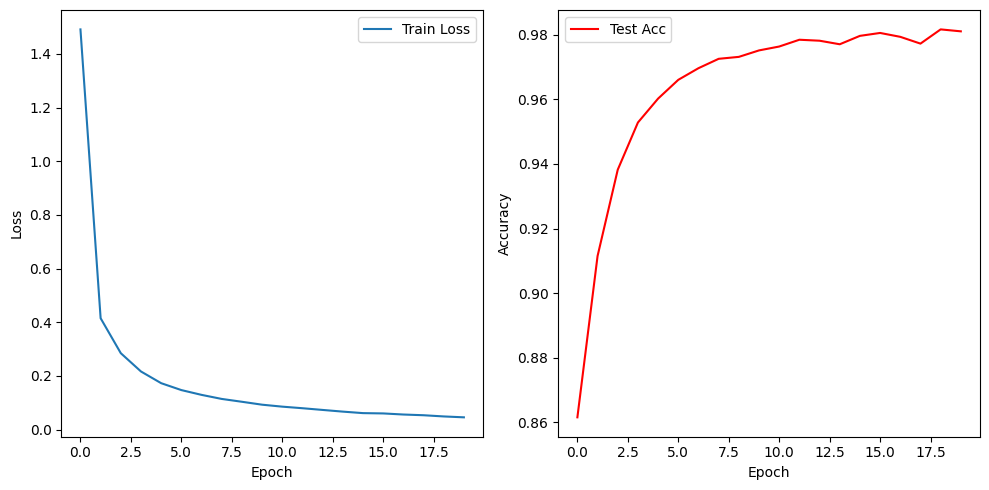

In [19]:
net = Net1(0.8) # dropout为0.8
optimizer = torch.optim.SGD(net.parameters(), lr)
train1(net, train_iter, loss, epochs, optimizer)